# Sampling
A common temptation to reduce the size of a point cloud for any number of reasons is to sample the data. In face, we have documented several methods in [tutorials](https://www.pdal.io/tutorial/dart-throwing.html) and workshop [exercises](https://www.pdal.io/workshop/exercises/analysis/thinning/thinning.html).

This tutorial will analyze point cloud sampling through the lens of the K-distance. K-distance is defined simply as the Euclidean distance to the k-th nearest neighbor. Perhaps unsurprisingly, we have a PDAL [filter](https://www.pdal.io/stages/filters.kdistance.html) that computes this very measure on a per point basis.

In this tutorial, we will use kernel density estimation to analyze the probability density of K-distances in the sample data as we apply several of the existing sampling techniques.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pdal
from sklearn.neighbors.kde import KernelDensity

And define our function for plotting the kernel density estimation for a particular dimension.

In [2]:
def dim_kde(arr, lb, ub, n=500, bw=0.25, k='epanechnikov'):
    f = plt.figure()
    xp = np.linspace(lb, ub, n)[:, np.newaxis]
    kde = KernelDensity(kernel=k, bandwidth=bw).fit(arr[:, np.newaxis])
    log_pdf = kde.score_samples(xp)
    # We add a few lines here to identify the peak of the KDE and report its location and magnitude.
    ind = np.argmax(np.exp(log_pdf))
    print(np.exp(log_pdf)[ind],xp[ind])
    ax = f.add_subplot(111)
    ax.plot(xp, np.exp(log_pdf))

We begin by loading the raw point cloud, and computing the K-distance to the nearest neighbor in 3D (`k=1`) with no sampling of the input data.

(0.95369271875360151, array([ 0.77755511]))


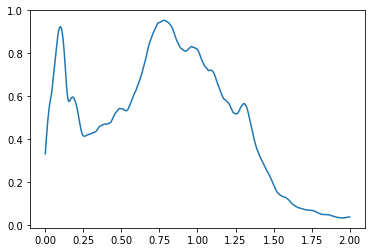

In [3]:
json = u'''
{
  "pipeline":[
    "./data/isprs/samp11-utm.laz",
    {
      "type":"filters.kdistance",
      "k":1
    }
  ]
}'''

p = pdal.Pipeline(json)
p.validate()
count = p.execute()
data = p.arrays[0]
dim_kde(data['KDistance'],0,2,bw=0.05)

(0.0, 0.083066238568517387, 1.5421413679708751, 19.429902213128301)


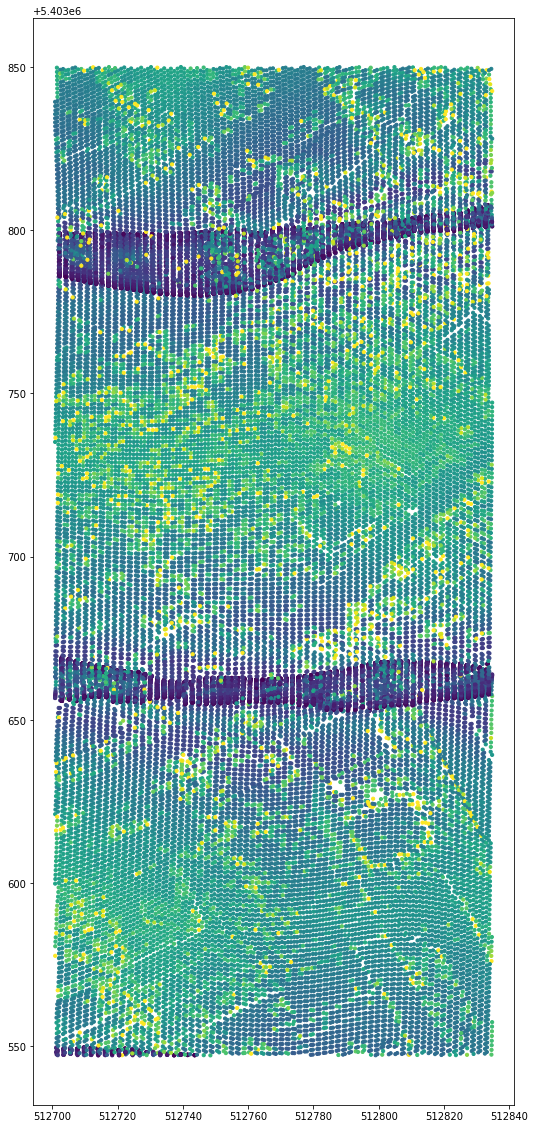

In [4]:
print(data['KDistance'].min(),np.percentile(data['KDistance'],5),np.percentile(data['KDistance'],95),data['KDistance'].max())
fig = plt.figure(figsize=(20,20))
ax = plt.axes(aspect='equal')
ax.scatter(data['X'],data['Y'],c=data['KDistance'],
#            vmin=np.percentile(data['KDistance'],5),
#            vmax=np.percentile(data['KDistance'],95),
           vmin=0,vmax=2,
           cmap='viridis', s=10)

In the previous example, we can clearly see two distinct peaks in the K-distance KDE. As it turns out, this particular dataset does in fact have a bimodel distribution of K-distances. This can be caused by scan patterns and flight line overlap. The higher density regions can sometimes be distracting, appearing as stripes across the data.

A naive and brute force way to mitigate this higher resolution (low K-distance) peak and to present a more uniformly sampled point cloud could be to simply filter out any point whose K-distance fell below a given threshold, say 0.3 meters where there seems to be a natural break between the two distributions. It may occur to you quite quickly why this would be a terrible idea. The `range` filter would indiscriminantly toss **all** points with a low K-distance. If our goals is to simply thin the point cloud, we would prefer to remove only select points (for example, just one, or perhaps even a few, that lie in a high density area, but not all). The downside to this is not apparent in the KDE alone. You will need to actually open the output LAZ file to see the affects. Try running the pipeline with different KDistance thresholds and observe.

30900 (81.294396%)
(1.173134635593033, array([ 0.77755511]))


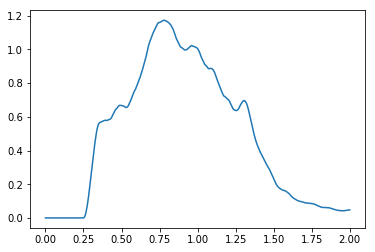

In [5]:
json = u'''
{
  "pipeline":[
    "./data/isprs/samp11-utm.laz",
    {
      "type":"filters.kdistance",
      "k":1
    },
    {
      "type":"filters.range",
      "limits":"KDistance[0.3:]"
    },
    "./range.laz"
  ]
}'''

p = pdal.Pipeline(json)
p.validate()
c = p.execute()
print('%d (%f%%)' % (c, 100.*c/count))
data = p.arrays[0]
dim_kde(data['KDistance'],0,2,bw=0.05)

(0.30000000041909519, 0.39115214443780499, 1.6142258202462374, 19.429902213128301)


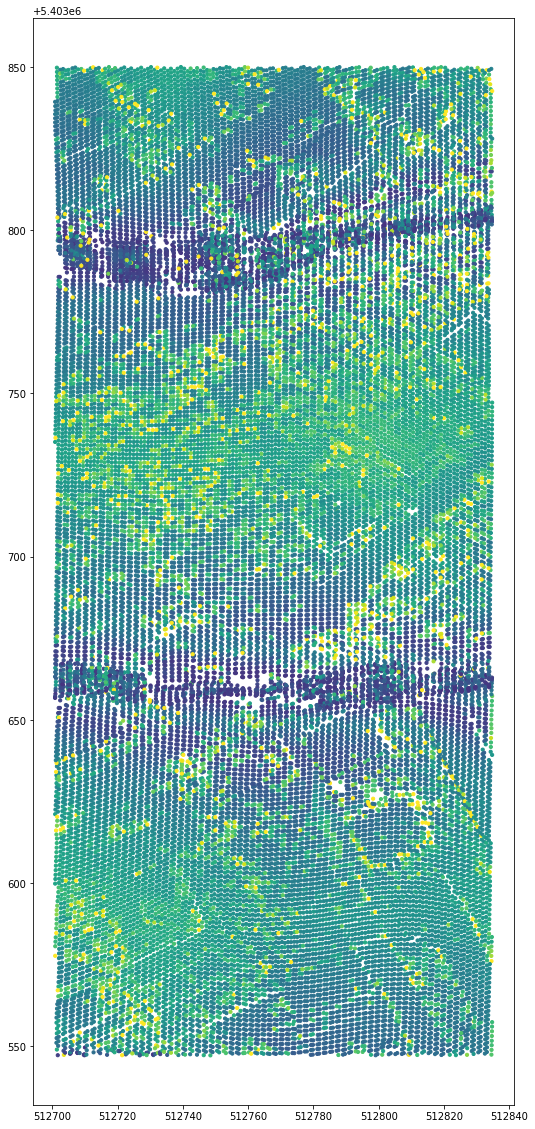

In [6]:
print(data['KDistance'].min(),np.percentile(data['KDistance'],5),np.percentile(data['KDistance'],95),data['KDistance'].max())
fig = plt.figure(figsize=(20,20))
ax = plt.axes(aspect='equal')
ax.scatter(data['X'],data['Y'],c=data['KDistance'],
#            vmin=np.percentile(data['KDistance'],5),
#            vmax=np.percentile(data['KDistance'],95),
           vmin=0,vmax=2,
           cmap='viridis', s=10)

Another temptation when it comes to thinning is to go with the method of decimating the point cloud, e.g., just keeping every n-th point. While this seems straightforward enough, it really isn't very meaningful. It really isn't possible to target a desired resolution, or number of output points, and it has a huge depedency on point order. In fact, we can see that while the cloud is reduced to half it's original size, we have the same basic bimodal distribution of K-distances.

19005 (50.000000%)
(0.70579562562207987, array([ 1.29458918]))


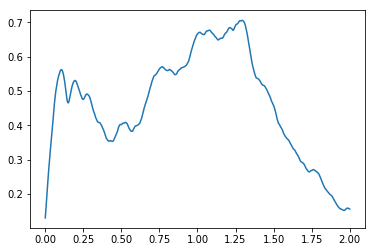

In [7]:
json = u'''
{
  "pipeline":[
    "./data/isprs/samp11-utm.laz",
    {
      "type":"filters.decimation",
      "step":2
    },
    {
      "type":"filters.kdistance",
      "k":1
    },
    "./decimation.laz"
  ]
}'''

p = pdal.Pipeline(json)
p.validate()
c = p.execute()
print('%d (%f%%)' % (c, 100.*c/count))
data = p.arrays[0]
dim_kde(data['KDistance'],0,2,bw=0.05)

(0.0099999999511055648, 0.11224972209584472, 2.1974211742012084, 19.429902213128301)


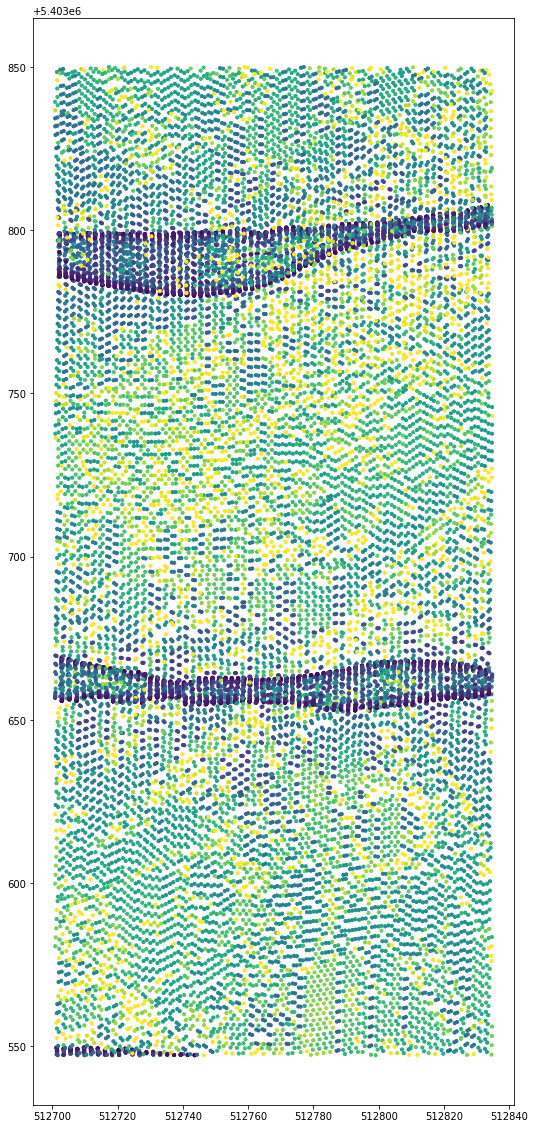

In [8]:
print(data['KDistance'].min(),np.percentile(data['KDistance'],5),np.percentile(data['KDistance'],95),data['KDistance'].max())
fig = plt.figure(figsize=(20,20))
ax = plt.axes(aspect='equal')
ax.scatter(data['X'],data['Y'],c=data['KDistance'],
#            vmin=np.percentile(data['KDistance'],5),
#            vmax=np.percentile(data['KDistance'],95),
           vmin=0,vmax=2,
           cmap='viridis', s=10)

Next, many users, especially those coming from PCL are familiar with the concept of thinning using a VoxelGrid, in which the centroid of points lying within 3D voxels are returned. Using VoxelGrid we can more closely control the average spacing of points in the output cloud (and the number of points). The thinning is also more statistically meaningful. We can see in the KDE that the lower peak is eliminated, while the rest of the plot closely resembles the original distribution of K-distances. (Some authors perform a similar technique, but return the raw point that is closest to either the 1) voxel center or the 2) computed centroid. This has the advantage of being able to passthrough per point dimensional data such as Classification or Intensity that would otherwise be lost. To date, neither of these variants exists within PDAL.)

35051 (92.215207%)
(1.0358017053373851, array([ 0.77755511]))


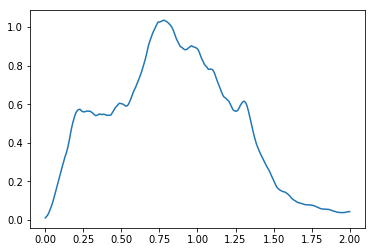

In [9]:
json = u'''
{
  "pipeline":[
    "./data/isprs/samp11-utm.laz",
    {
      "type":"filters.voxelgrid",
      "leaf_x":0.3,
      "leaf_y":0.3,
      "leaf_z":0.3
    },
    {
      "type":"filters.kdistance",
      "k":1
    },
    "./voxelgrid.laz"
  ]
}'''

p = pdal.Pipeline(json)
p.validate()
c = p.execute()
print('%d (%f%%)' % (c, 100.*c/count))
data = p.arrays[0]
dim_kde(data['KDistance'],0,2,bw=0.05)

(0.022358632853958418, 0.20049654551770696, 1.5710060509403232, 19.429907992156139)


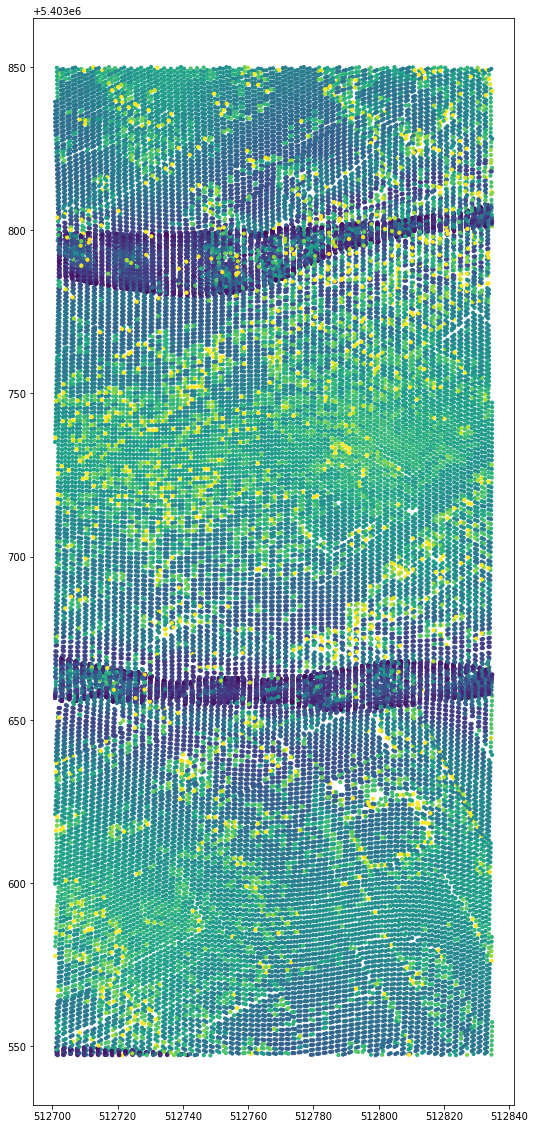

In [10]:
print(data['KDistance'].min(),np.percentile(data['KDistance'],5),np.percentile(data['KDistance'],95),data['KDistance'].max())
fig = plt.figure(figsize=(20,20))
ax = plt.axes(aspect='equal')
ax.scatter(data['X'],data['Y'],c=data['KDistance'],
#            vmin=np.percentile(data['KDistance'],5),
#            vmax=np.percentile(data['KDistance'],95),
           vmin=0,vmax=2,
           cmap='viridis', s=10)

The final approach performs Poission disk sampling, where a minimum separating distance between any two points is enforced. This has the advantage of enforcing a hard threshold (similar to applying the Range filter) where by no point will have a K-distance smaller than the specified threshold, while ensuring that points are still sampled from both the high and low density areas. As with VoxelGrid, we can see that the KDE maintains the same basic shape as the raw data, except as we approach the threshold value of 0.3.

33130 (87.161273%)
(1.1094126631802923, array([ 0.77755511]))


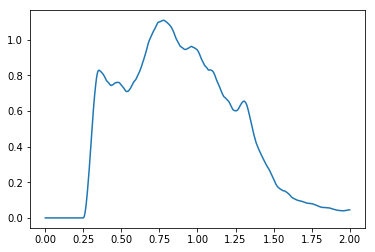

In [11]:
json = u'''
{
  "pipeline":[
    "./data/isprs/samp11-utm.laz",
    {
      "type":"filters.sample",
      "radius":0.3
    },
    {
      "type":"filters.kdistance",
      "k":1
    },
    "./poisson.laz"
  ]
}'''

p = pdal.Pipeline(json)
p.validate()
c = p.execute()
print('%d (%f%%)' % (c, 100.*c/count))
data = p.arrays[0]
dim_kde(data['KDistance'],0,2,bw=0.05)

(0.30000000024834134, 0.36027767096744528, 1.5940561341649306, 19.429902213128301)


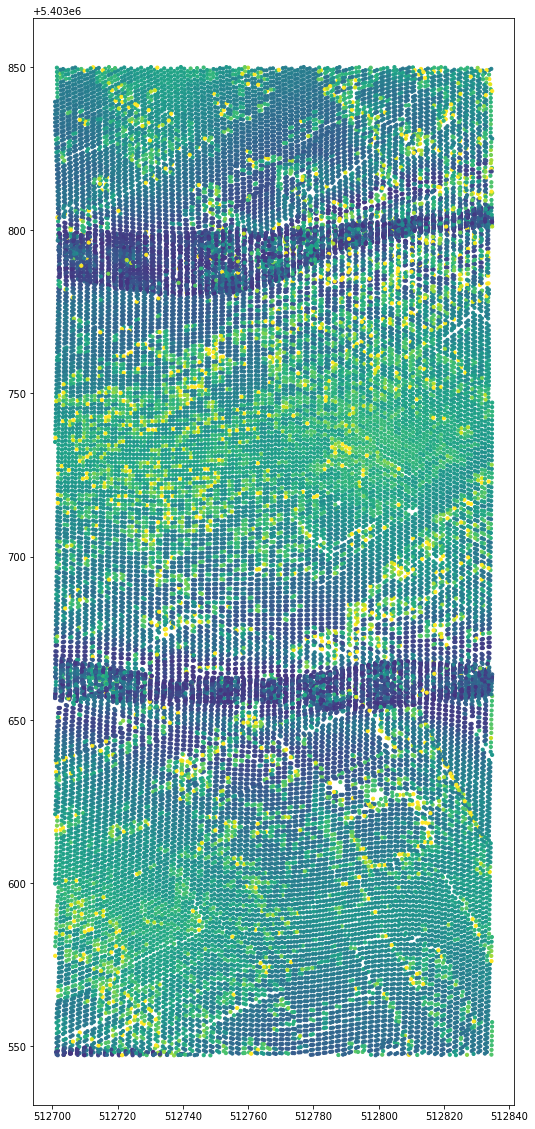

In [12]:
print(data['KDistance'].min(),np.percentile(data['KDistance'],5),np.percentile(data['KDistance'],95),data['KDistance'].max())
fig = plt.figure(figsize=(20,20))
ax = plt.axes(aspect='equal')
ax.scatter(data['X'],data['Y'],c=data['KDistance'],
#            vmin=np.percentile(data['KDistance'],5),
#            vmax=np.percentile(data['KDistance'],95),
           vmin=0,vmax=2,
           cmap='viridis', s=10)